In [ ]:
] add DataFrames

In [1]:
using DrWatson
using Plots
using DataFrames
import PartitionedArraysBenchmarks as pb

Precompiling PartitionedArraysBenchmarks
  ✓ PartitionedArraysBenchmarks
  1 dependency successfully precompiled in 4 seconds. 64 already precompiled.


In [341]:
path = mkpath("results")
cmd = :sbatch
function reduce_timing(ts)
    nworkers = length(ts)
    nruns = length(first(ts))
    t = minimum(ir->maximum(iw->ts[iw][ir],1:nworkers),1:nruns)
    t
end
filename = params -> joinpath(path,pb.jobname(params))
function parts_per_dir_array(P,D,m=prod(P))
    cis = CartesianIndices(P)
    a = filter(cis) do ci
        t = Tuple(ci)
        issorted(t) && maximum(t)-minimum(t)<=1 && prod(t) <= m
    end
    map(a) do a
        ntuple(D) do d
            if d > length(P)
                return 1
            end
            Int(a[d])
        end
    end
end
function optimal(x,y)
    x1 = x[1]
    y1 = y[1]
    C = y1/x1
    K = y1 - C / x1
    C ./ x .+ K
end
template = raw"""
#!/bin/bash
#SBATCH --time=00:45:00
#SBATCH --nodes={{{nodes}}}
#SBATCH --ntasks-per-node=24
#SBATCH --output={{{__JOBNAME__}}}.o
#SBATCH --error={{{__JOBNAME__}}}.e

export OMP_NUM_THREADS=1
export NUM_THREADS=1
mpiexec -np {{{np}}} --map-by node:span --rank-by core julia --project={{{__PROJECT__}}} -O3 --check-bounds=no -e '
   import PartitionedArraysBenchmarks as pb
   import PartitionedArrays as pa
   params = {{{__PARAMS__}}}
   jobname = "{{{__JOBNAME__}}}"
   pa.with_mpi() do distribute
       pb.experiment(pb.{{{benchmark}}},jobname,distribute,params)
   end
'
"""
function run_experiment(params;launch=false,force=false)
    if !launch
        fn = filename(params)
        if force || ! isfile(fn*".sh")
        @info "Would run $(fn)"
        end
        return
    end
    produce_or_load(params;filename,force,tag=false) do params
        pb.runjob(cmd,template,params;filename)
        Dict{String,Any}()
    end
end

run_experiment (generic function with 1 method)

In [149]:
cores_per_node = 24
cores_per_dir_3d = parts_per_dir_array((100,100,100),3,cores_per_node)
cores_per_dir_2d = parts_per_dir_array((100,100),3,cores_per_node)
cores_per_dir_1d = parts_per_dir_array((100,),3,cores_per_node)
nodes_in_cluster = 8
nodes_per_dir_3d = parts_per_dir_array((100,100,100),3,nodes_in_cluster)
nodes_per_dir_2d = parts_per_dir_array((100,100),3,nodes_in_cluster)
nodes_per_dir_1d = parts_per_dir_array((100,),3,nodes_in_cluster);

## SpMV

In [343]:
methods_space = ["Petsc","PartitionedArrays"]
param_space = Dict(
    :nodes_per_dir => nodes_per_dir_3d[1:1],
    :cores_per_dir => cores_per_dir_3d[1:1],
    :method => methods_space,
    :cells_per_dir => [(400,400,400)],
    :nruns => 10,
    :benchmark => :benchmark_spmv,
)
params = dict_list(param_space)
params = map(params) do dict
    dict[:parts_per_dir] = dict[:nodes_per_dir].*dict[:cores_per_dir]
    dict[:nodes] = prod(dict[:nodes_per_dir])
    dict[:np] = prod(dict[:parts_per_dir])
    dict
end;
for params in params
    run_experiment(params;launch=false)
end

In [291]:
files = readdir(path)
files = filter(f->occursin("_results",f),files)
dicts = map(f->load(joinpath(path,f)),files)
dicts = filter(d->d["benchmark"]=== :benchmark_spmv,dicts)
df = DataFrame(dicts)
df[!,:spmv] = reduce_timing.(df[!,:spmv])
sort!(df,[:method,:np])
df;

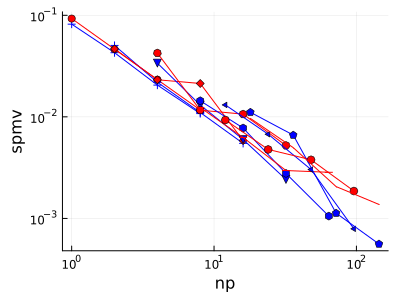

In [312]:
colors = [:blue,:red]
xkey = :np
ykey = :spmv
vkey = :nodes
mkey = :method
mvals = ["PartitionedArrays","Petsc"]
nkey = :cores_per_dir
nvals = cores_per_dir_3d
fixed = Dict(:cells_per_dir=>(400,400,400))
plt = plot(size=(400,300),xlabel=xkey,ylabel=ykey)
for nval in nvals
    for mval in mvals
        function take_row(row)
            bool = row[mkey] == mval && row[nkey] == nval
            for (key,val) in fixed
                bool = bool && row[key] == val
            end
            bool
        end
        df_filtered = filter(take_row,df)
        sort!(df_filtered,[vkey])
        x = df_filtered[:,xkey]
        y = df_filtered[:,ykey]
        plot!(x,y,label="$mval $nval",color=colors[findfirst(i->i==mval,mvals)], markers=:auto,xaxis=:log,yaxis=:log,legend=nothing)
    end
end
plt

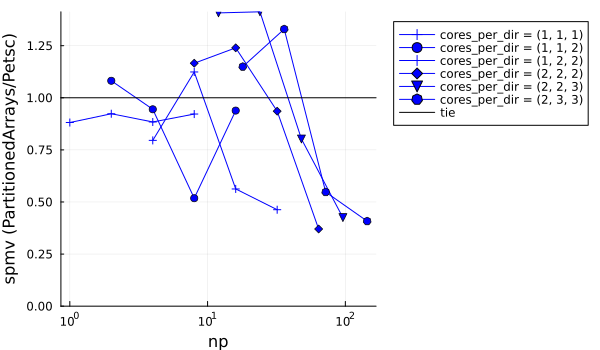

In [337]:
xkey = :np
ykey = :spmv
vkey = :nodes
mkey = :method
mvals = ["PartitionedArrays","Petsc"]
nkey = :cores_per_dir
nvals = cores_per_dir_3d
fixed = Dict(:cells_per_dir=>(400,400,400))
plt = plot(size=(600,350),xlabel=xkey,ylabel="$ykey ($(mvals[1])/$(mvals[2]))")
for nval in nvals    
        function take_row(row)
            bool = row[nkey] == nval
            for (key,val) in fixed
                bool = bool && row[key] == val
            end
            bool
        end
        df_filtered = filter(take_row,df)
        dg = groupby(df_filtered,vkey)
        dh = combine(dg) do sdf
           i1 = findfirst(sdf[!,mkey] .== mvals[1] )
           i2 = findfirst(sdf[!,mkey] .== mvals[2] )
           yval = sdf[i1,ykey]/sdf[i2,ykey]
           sdf[!,ykey] .= yval
           sdf[1,[vkey,xkey,ykey]]
        end
        sort!(dh,[vkey])
        x = dh[:,xkey]
        y = dh[:,ykey]
        plot!(x,y,label="$nkey = $nval",color=:blue, markers=:auto,xaxis=:log,ylimits=[0,Inf],legend=:outertopright)
end
xlms = xlims(plt)
plot!([xlms...],[1.,1.],label="tie",color=:black,xlimits=xlms)
plt

In [ ]:
cells_per_dir = (100,100,100)
df = filter(row->row.cells_per_dir == cells_per_dir,df)

Row,nodes,cells_per_dir,cores_per_dir,method,parts_per_dir,spmv,np,nruns,benchmark,nodes_per_dir
,Int64,Tuple…,Tuple…,String,Tuple…,Float64,Int64,Int64,Symbol,Tuple…
1,1,"(100, 100, 100)","(1, 1, 1)",Petsc,"(1, 1, 1)",0.0013633,1,10,benchmark_spmv,"(1, 1, 1)"
2,1,"(100, 100, 100)","(1, 1, 2)",Petsc,"(1, 1, 2)",0.000682595,2,10,benchmark_spmv,"(1, 1, 1)"
3,2,"(100, 100, 100)","(1, 1, 1)",Petsc,"(1, 1, 2)",0.000686542,2,10,benchmark_spmv,"(1, 1, 2)"
4,1,"(100, 100, 100)","(1, 2, 2)",Petsc,"(1, 2, 2)",0.000641703,4,10,benchmark_spmv,"(1, 1, 1)"
5,2,"(100, 100, 100)","(1, 1, 2)",Petsc,"(1, 1, 4)",0.000341239,4,10,benchmark_spmv,"(1, 1, 2)"
6,4,"(100, 100, 100)","(1, 1, 1)",Petsc,"(1, 2, 2)",0.000345496,4,10,benchmark_spmv,"(1, 2, 2)"
7,8,"(100, 100, 100)","(1, 1, 1)",Petsc,"(2, 2, 2)",0.000174567,8,10,benchmark_spmv,"(2, 2, 2)"
8,1,"(100, 100, 100)","(2, 2, 2)",Petsc,"(2, 2, 2)",0.000185777,8,10,benchmark_spmv,"(1, 1, 1)"
9,4,"(100, 100, 100)","(1, 1, 2)",Petsc,"(1, 2, 4)",0.000185688,8,10,benchmark_spmv,"(1, 2, 2)"


## SpMV old

In [82]:
a = parts_per_dir_array((5,5,5),3,8)
map(i-> i=> prod(i),a)

4-element Vector{Pair{Tuple{Int64, Int64, Int64}, Int64}}:
 (1, 1, 1) => 1
 (1, 1, 2) => 2
 (1, 2, 2) => 4
 (2, 2, 2) => 8

In [35]:
parts_per_dir_space = [(2,2,2)]
methods_space = ["Petsc"]
param_space = Dict(
    :nodes => 2,
    :np => Derived(:parts_per_dir,prod),
    :method => methods_space,
    :cells_per_dir => [(100,100,100)],
    :parts_per_dir => parts_per_dir_space,
    :nruns => 10,
    :benchmark => :benchmark_spmv,
)
params = dict_list(param_space)
for params in params
    run_experiment(params;dryrun=false)
end

[ Info: File results/ecd59dec8bded789.jld2 does not exist. Producing it now...


Submitted batch job 248404


[ Info: File results/ecd59dec8bded789.jld2 saved.


In [ ]:
#parts_per_dir_space = [(1,1,1)]#,(2,1,1),(3,1,1),(4,1,1),(5,1,1)]
parts_per_dir_space = parts_per_dir_array((3,3,3),3)
methods_space = ["PartitionedArrays","Petsc"]
param_space = Dict(
    :nodes => 2,
    :ntasks_per_node => Derived(:parts_per_dir,prod),
    :np => Derived(:parts_per_dir,prod),
    :method => methods_space,
    :cells_per_dir => [(600,600,600)],
    :parts_per_dir => parts_per_dir_space,
    :nruns => 10,
    :benchmark => :benchmark_spmv,
)

In [ ]:
params = dict_list(param_space)
for params in params
    produce_or_load(params;filename,tag=false) do params
        pb.runjob(cmd,params;filename)
        Dict{String,Any}()
    end
end

In [ ]:
files = readdir(path)
files = filter(f->occursin("_results",f),files)
dicts = map(f->load(joinpath(path,f)),files)
dicts = filter(d->d["benchmark"]=== :benchmark_spmv,dicts)
df = DataFrame(dicts)
df[!,:spmv] = reduce_timing.(df[!,:spmv])
sort!(df,[:method,:np])
cells_per_dir = (400,400,400)
df = filter(row->row.cells_per_dir == cells_per_dir,df)

In [ ]:
plt = plot(size=(400,300),xlabel="P",ylabel="Wall time [s]")
for method in ["PartitionedArrays","Petsc"]
    take_row(row) = row.method == method && row.cells_per_dir == cells_per_dir
    df_filtered = filter(take_row,df)
    sort!(df_filtered,[:np])
    x = df_filtered[:,:np]
    y = df_filtered[:,:spmv]
    plot!(x,y,label=method,markers=:auto,xaxis=:log,yaxis=:log)
    o = optimal(x,y)
    plot!(x,o,markers=:none,label=:none,color=:black,xaxis=:log,yaxis=:log)
end
plt

## Matrix assembly

In [ ]:
#parts_per_dir_space = [(1,1,1),(2,1,1),(3,1,1),(4,1,1)]
parts_per_dir_space = parts_per_dir_array((3,3,3),3)
methods_space = ["psprse","petsc_coo"]
param_space = Dict(
    :nodes => 1,
    :ntasks_per_node => Derived(:parts_per_dir,prod),
    :np => Derived(:parts_per_dir,prod),
    :method => methods_space,
    :cells_per_dir => [(400,400,400)],
    :parts_per_dir => parts_per_dir_space,
    :nruns => 10,
    :benchmark => :benchmark_psparse,
)
params = dict_list(param_space)
for params in params
    produce_or_load(params;filename,tag=false) do params
        pb.runjob(cmd,params;filename)
        Dict{String,Any}()
    end
end

In [ ]:
files = readdir(path)
files = filter(f->occursin("_results",f),files)
dicts = map(f->load(joinpath(path,f)),files)
dicts = filter(d->d["benchmark"]=== :benchmark_psparse,dicts)
df = DataFrame(dicts)
df[!,:buildmat] = reduce_timing.(df[!,:buildmat])
df[!,:rebuildmat] = reduce_timing.(df[!,:rebuildmat])
sort!(df,[:method,:np])
cells_per_dir = (400,400,400)
df = filter(row->row.cells_per_dir == cells_per_dir,df)

In [ ]:
plt = plot(size=(400,300),xlabel="P",ylabel="Wall time [s]")
for method in ["psprse","petsc_coo"]
    take_row(row) = row.method == method && row.cells_per_dir == cells_per_dir
    df_filtered = filter(take_row,df)
    sort!(df_filtered,[:np])
    x = df_filtered[:,:np]
    y = df_filtered[:,:buildmat]
    plot!(x,y,label=method,markers=:auto,xaxis=:log,yaxis=:log)
    o = optimal(x,y)
    plot!(x,o,markers=:none,color=:black,xaxis=:log,yaxis=:log)
end
plt

In [ ]:
; squeue

In [ ]:
; ls results

In [ ]:
; cat results/060a76c710844502.sh

In [287]:
?groupby

search: groupby groupcols groupindices GroupedDataFrame



```
groupby(d::AbstractDataFrame, cols;
        sort::Union{Bool, Nothing, NamedTuple}=nothing,
        skipmissing::Bool=false)
```

Return a `GroupedDataFrame` representing a view of an `AbstractDataFrame` split into row groups.

# Arguments

  * `df` : an `AbstractDataFrame` to split
  * `cols` : data frame columns to group by. Can be any column selector (`Symbol`, string or integer; `:`, `Cols`, `All`, `Between`, `Not`, a regular expression, or a vector of `Symbol`s, strings or integers). In particular if the selector picks no columns then a single-group `GroupedDataFrame` is created. As a special case, if `cols` is a single column or a vector of columns then it can contain columns wrapped in [`order`](@ref) that will be used to determine the order of groups if `sort` is `true` or a `NamedTuple` (if `sort` is `false`, then passing `order` is an error; if `sort` is `nothing` then it is set to `true` when `order` is passed).
  * `sort` : if `sort=true` sort groups according to the values of the grouping columns `cols`; if `sort=false` groups are created in their order of appearance in `df`; if `sort=nothing` (the default) then the fastest available grouping algorithm is picked and in consequence the order of groups in the result is undefined and may change in future releases; below a description of the current implementation is provided. Additionally `sort` can be a `NamedTuple` having some or all of `alg`, `lt`, `by`, `rev`, and `order` fields. In this case the groups are sorted and their order follows the [`sortperm`](@ref) order.
  * `skipmissing` : whether to skip groups with `missing` values in one of the grouping columns `cols`

# Details

An iterator over a `GroupedDataFrame` returns a `SubDataFrame` view for each grouping into `df`. Within each group, the order of rows in `df` is preserved.

A `GroupedDataFrame` also supports indexing by groups, `select`, `transform`, and `combine` (which applies a function to each group and combines the result into a data frame).

`GroupedDataFrame` also supports the dictionary interface. The keys are [`GroupKey`](@ref) objects returned by [`keys(::GroupedDataFrame)`](@ref), which can also be used to get the values of the grouping columns for each group. `Tuples` and `NamedTuple`s containing the values of the grouping columns (in the same order as the `cols` argument) are also accepted as indices. Finally, an `AbstractDict` can be used to index into a grouped data frame where the keys are column names of the data frame. The order of the keys does not matter in this case.

In the current implementation if `sort=nothing` groups are ordered following the order of appearance of values in the grouping columns, except when all grouping columns provide non-`nothing` `DataAPI.refpool`, in which case the order of groups follows the order of values returned by `DataAPI.refpool`. As a particular application of this rule if all `cols` are `CategoricalVector`s then groups are always sorted. Integer columns with a narrow range also use this this optimization, so to the order of groups when grouping on integer columns is undefined. A column is considered to be an integer column when deciding on the grouping algorithm choice if its `eltype` is a subtype of `Union{Missing, Real}`, all its elements are either `missing` or pass `isinteger` test, and none of them is equal to `-0.0`.

# See also

[`combine`](@ref), [`select`](@ref), [`select!`](@ref), [`transform`](@ref), [`transform!`](@ref)

# Examples

```jldoctest
julia> df = DataFrame(a=repeat([1, 2, 3, 4], outer=[2]),
                      b=repeat([2, 1], outer=[4]),
                      c=1:8);

julia> gd = groupby(df, :a)
GroupedDataFrame with 4 groups based on key: a
First Group (2 rows): a = 1
 Row │ a      b      c
     │ Int64  Int64  Int64
─────┼─────────────────────
   1 │     1      2      1
   2 │     1      2      5
⋮
Last Group (2 rows): a = 4
 Row │ a      b      c
     │ Int64  Int64  Int64
─────┼─────────────────────
   1 │     4      1      4
   2 │     4      1      8

julia> gd[1]
2×3 SubDataFrame
 Row │ a      b      c
     │ Int64  Int64  Int64
─────┼─────────────────────
   1 │     1      2      1
   2 │     1      2      5

julia> last(gd)
2×3 SubDataFrame
 Row │ a      b      c
     │ Int64  Int64  Int64
─────┼─────────────────────
   1 │     4      1      4
   2 │     4      1      8

julia> gd[(a=3,)]
2×3 SubDataFrame
 Row │ a      b      c
     │ Int64  Int64  Int64
─────┼─────────────────────
   1 │     3      2      3
   2 │     3      2      7

julia> gd[Dict("a" => 3)]
2×3 SubDataFrame
 Row │ a      b      c
     │ Int64  Int64  Int64
─────┼─────────────────────
   1 │     3      2      3
   2 │     3      2      7

julia> gd[(3,)]
2×3 SubDataFrame
 Row │ a      b      c
     │ Int64  Int64  Int64
─────┼─────────────────────
   1 │     3      2      3
   2 │     3      2      7

julia> k = first(keys(gd))
GroupKey: (a = 1,)

julia> gd[k]
2×3 SubDataFrame
 Row │ a      b      c
     │ Int64  Int64  Int64
─────┼─────────────────────
   1 │     1      2      1
   2 │     1      2      5

julia> for g in gd
           println(g)
       end
2×3 SubDataFrame
 Row │ a      b      c
     │ Int64  Int64  Int64
─────┼─────────────────────
   1 │     1      2      1
   2 │     1      2      5
2×3 SubDataFrame
 Row │ a      b      c
     │ Int64  Int64  Int64
─────┼─────────────────────
   1 │     2      1      2
   2 │     2      1      6
2×3 SubDataFrame
 Row │ a      b      c
     │ Int64  Int64  Int64
─────┼─────────────────────
   1 │     3      2      3
   2 │     3      2      7
2×3 SubDataFrame
 Row │ a      b      c
     │ Int64  Int64  Int64
─────┼─────────────────────
   1 │     4      1      4
   2 │     4      1      8
```


In [288]:
df = DataFrame(a=repeat([1, 2, 3, 4], outer=[2]),
                      b=repeat([2, 1], outer=[4]),
                      c=1:8)

Row,a,b,c
,Int64,Int64,Int64
1,1,2,1
2,2,1,2
3,3,2,3
4,4,1,4
5,1,2,5
6,2,1,6
7,3,2,7
8,4,1,8


In [289]:
gd = groupby(df, :a)

Row,a,b,c
,Int64,Int64,Int64
1,1,2,1
2,1,2,5
Row,a,b,c
,Int64,Int64,Int64
1,4,1,4
2,4,1,8
